# Tutorial Multi-Pitch Estimation (MPE) based on HCQT/Conv2D/U-Net

- date: 2024-10-10
- author: geoffroy.peeters@telecom-paris.fr

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
It illustrates the use of various deep-learning bricks to solve the task of "Multi-Pitch-Estimation".


Part of the code is based on 
- "Deep Salience" model: https://github.com/rabitt/ismir-2021-tutorial-case-studies/tree/main/pitch_tracking

In [1]:
do_deploy = False

In [2]:
if do_deploy:
    !git clone https://github.com/geoffroypeeters/DL101forMIR_notebook.git
    %cd DL101forMIR_notebook
    !ls

## Import packages

In [3]:
import torch
from torch import nn
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os


import librosa
import numpy as np
import matplotlib.pyplot as plt
import feature

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

# -----------------------------
! pip install mir_eval --quiet
import mir_eval

## Parameters

In [4]:
if do_deploy:
    import urllib.request
    import shutil
    ROOT = 'https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/'
    
    #hdf5_audio_file, pyjama_annot_file = 'bach10_audio.hdf5.zip', 'bach10.pyjama'
    hdf5_audio_file, file_annot = 'maps_audio.hdf5.zip', 'maps.pyjama'
    
    urllib.request.urlretrieve(ROOT + hdf5_audio_file, hdf5_audio_file)
    if hdf5_audio_file.endswith('.zip'): shutil.unpack_archive(hdf5_audio_file, './')
    urllib.request.urlretrieve(ROOT + pyjama_annot_file, pyjama_annot_file)

    ROOT = './'

else:

    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

In [6]:
#base, do_f0_annot = 'bach10', 'frame'
base, do_f0_annot = 'maps', 'segment'

hdf5_audio_file = f'{ROOT}/{base}_audio.hdf5'
hdf5_feat_file = f'{ROOT}/{base}_feat.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'

param_patch = Namespace()
param_patch.L_frame = 64
param_patch.STEP_frame = int(param_patch.L_frame/2)

param_model = Namespace()
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param_model.batch_size = 32

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='./_pitch_lighning/'
param_lightning.filename='best_model_pitch'

param_wandb = Namespace()
param_wandb.save_dir = './_pitch_wandb/'
param_wandb.project_name = 'wandb_pitch'


## Dataloader

### Test loading pyjama/hdf5

In [10]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
pp.pprint(audiofile_l[:5])


with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    pp.pprint(f"audio shape: {hdf5_fid[audiofile_l[0]][:].shape}")
    pp.pprint(f"audio sample-rate: {hdf5_fid[audiofile_l[0]].attrs['sr_hz']}")
    #pp.pprint(hdf5_fid['/'].keys())

number of audio: 270
['MAPS_MUS-alb_se3_AkPnBcht.wav',
 'MAPS_MUS-bach_846_AkPnBcht.wav',
 'MAPS_MUS-bach_847_AkPnBcht.wav',
 'MAPS_MUS-bk_xmas5_AkPnBcht.wav',
 'MAPS_MUS-chp_op31_AkPnBcht.wav']
'audio shape: (5514216,)'
'audio sample-rate: 22050'


### Define features

In [11]:
midi_to_f0 = lambda midi: 440*2**((midi-69)/12)
f0_to_midi = lambda f0: np.log2(f0/440)*12+69
flog = lambda x: np.log(1+1000*x)-np.log(1+1000)

In [12]:
param_hcqt = Namespace()
param_hcqt.tmp_dir = './_pitch_feature/'
#param_hcqt.h_l = [1] # --- CQT
param_hcqt.h_l = [0.5, 1, 2, 3, 4, 5] # --- HCQT
BINS_PER_SEMITONE = 5
N_OCTAVES = 6
param_hcqt.BINS_PER_OCTAVE = 12 * BINS_PER_SEMITONE
param_hcqt.N_BINS = N_OCTAVES * param_hcqt.BINS_PER_OCTAVE
param_hcqt.FMIN = 32.7
param_hcqt.HOP_LENGTH = 512


In [13]:
# --- TEST
idx_file = 0
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
CQT_3m, cqt_time_sec_v, cqt_frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, param_hcqt)
print(f'{CQT_3m.shape} {cqt_frequency_hz_v[0], cqt_frequency_hz_v[-1]}')

(6, 360, 10770) (32.7, 2068.762141794541)


#### Batch/parrallel processing of feature extraction

In [14]:
def f_parrallel(audio_file):
    """
    """
    with h5py.File(hdf5_audio_file, 'r') as audio_fid:
        audio_value_v = audio_fid[audio_file][:]
        audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
        cqt_value_3m, cqt_time_sec_v, cqt_frequency_hz_v = feature.f_get_hcqt(audio_value_v, audio_sr_hz, param_hcqt)
        if not os.path.exists(param_hcqt.tmp_dir):
            os.makedirs(param_hcqt.tmp_dir)
        np.savez(f"{param_hcqt.tmp_dir}/{audio_file}.npz", cqt_value_3m=cqt_value_3m, cqt_time_sec_v=cqt_time_sec_v, cqt_frequency_hz_v=cqt_frequency_hz_v)

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_file_l = [audio_file for audio_file in hdf5_fid['/'].keys()]
print(audio_file_l)

with Pool(16) as p: p.map(f_parrallel, audio_file_l)

with h5py.File(hdf5_feat_file, 'w') as feat_fid:
    for audio_file in tqdm(audio_file_l):
        data = np.load(f"{param_hcqt.tmp_dir}/{audio_file}.npz")
        feat_fid['/' + audio_file + '/cqt_value_3m/'] = data['cqt_value_3m']
        feat_fid['/' + audio_file + '/cqt_time_sec_v/'] = data['cqt_time_sec_v']
        feat_fid['/' + audio_file + '/cqt_frequency_hz_v/'] = data['cqt_frequency_hz_v']

['MAPS_MUS-alb_esp2_AkPnCGdD.wav', 'MAPS_MUS-alb_esp2_AkPnStgb.wav', 'MAPS_MUS-alb_esp2_SptkBGAm.wav', 'MAPS_MUS-alb_esp2_SptkBGCl.wav', 'MAPS_MUS-alb_esp3_AkPnCGdD.wav', 'MAPS_MUS-alb_esp4_AkPnStgb.wav', 'MAPS_MUS-alb_esp5_SptkBGCl.wav', 'MAPS_MUS-alb_esp6_SptkBGCl.wav', 'MAPS_MUS-alb_se2_ENSTDkCl.wav', 'MAPS_MUS-alb_se2_StbgTGd2.wav', 'MAPS_MUS-alb_se3_AkPnBcht.wav', 'MAPS_MUS-alb_se3_AkPnBsdf.wav', 'MAPS_MUS-alb_se4_AkPnBsdf.wav', 'MAPS_MUS-alb_se6_AkPnStgb.wav', 'MAPS_MUS-alb_se7_AkPnBsdf.wav', 'MAPS_MUS-alb_se8_SptkBGAm.wav', 'MAPS_MUS-appass_1_AkPnBsdf.wav', 'MAPS_MUS-appass_1_SptkBGCl.wav', 'MAPS_MUS-appass_3_AkPnStgb.wav', 'MAPS_MUS-bach_846_AkPnBcht.wav', 'MAPS_MUS-bach_846_SptkBGAm.wav', 'MAPS_MUS-bach_847_AkPnBcht.wav', 'MAPS_MUS-bach_847_AkPnStgb.wav', 'MAPS_MUS-bach_847_SptkBGCl.wav', 'MAPS_MUS-bach_850_AkPnBsdf.wav', 'MAPS_MUS-bk_xmas1_AkPnBsdf.wav', 'MAPS_MUS-bk_xmas1_AkPnStgb.wav', 'MAPS_MUS-bk_xmas1_ENSTDkAm.wav', 'MAPS_MUS-bk_xmas1_ENSTDkCl.wav', 'MAPS_MUS-bk_xmas1_St

100%|██████████| 270/270 [04:02<00:00,  1.11it/s]


In [15]:
# --- TEST
feature.f_get_patches(T=250, L=64, S=32)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Define mapping

#### Frame-based f0 annotations

In [16]:
def f_map_annot_frame_based(cqt_time_sec_v, cqt_frequency_hz_v, f0multi_entry_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as frame-based f0

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        f0multi_entry_l contains a multi-beakpoint which fields 
            'time' (nb_time)
            'value' (nb_dim, nb_time)
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
    
    nb_freq = len(cqt_frequency_hz_v)
    nb_frame = len(cqt_time_sec_v)
    cqt_f0_value_m = np.zeros( (nb_freq, nb_frame) )
    
    gt_time_sec_v = np.asarray(f0multi_entry_l[0]['time'])
    gt_f0_midi_m = np.asarray(f0multi_entry_l[0]['value']).T
    nb_stem = gt_f0_midi_m.shape[0]
    
    # --- gt_f0_midi_m (nb_stem, nb_time)
    for num_stem in range(nb_stem):
        for num_frame in range(nb_frame):
            # --- for each time of the CQT we look for the closest ground-truth time
            pos_frame = np.argmin(np.abs(gt_time_sec_v - cqt_time_sec_v[num_frame]))
            # --- we then look for the closest CQT frequency to the ground-truth f0
            gt_f0_hz = midi_to_f0(gt_f0_midi_m[num_stem, pos_frame])
            pos_freq = np.argmin(np.abs(gt_f0_hz-cqt_frequency_hz_v))
            cqt_f0_value_m[pos_freq, num_frame] = 1
    return cqt_f0_value_m

In [17]:
# --- TEST
if do_f0_annot == 'frame':
    idx_file = 4
    with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
        audio_v = hdf5_fid[audiofile_l[idx_file]][:]
        sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
    entry = data_d['collection']['entry'][idx_file]

    cqt_d = Namespace()
    cqt_d.value_3m, cqt_d.time_sec_v, cqt_d.frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, param_hcqt)
    cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])

    # -------------------------------
    plt.figure(figsize=(10,6));
    D=1/2
    plt.subplot(111); 
    plt.imshow(flog(cqt_d.value_3m[param_hcqt.h_l.index(1),:,:]), aspect='auto', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D]);
    plt.imshow(flog(cqt_d.f0_value_m), aspect='auto', cmap='Reds', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D], alpha=0.4);
    plt.colorbar();
    # -------------------------------

#### Segment-based (start, stop, value) f0 annotations

In [18]:
def f_map_annot_segment_based(cqt_time_sec_v, cqt_frequency_hz_v, segment_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as segment of notes

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        segment_l  a list of segments each is a dictionary {'start': , 'stop:', 'value': }
            value is given in midi-float unit
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
     
    cqt_f0_value_m = np.zeros( (len(cqt_frequency_hz_v), len(cqt_time_sec_v)) )
    for note_d in segment_l:
        pos_start = np.argmin(np.abs(note_d['time']-cqt_time_sec_v))
        pos_stop = np.argmin(np.abs(note_d['time']+note_d['duration']-cqt_time_sec_v))
        pos_value = np.argmin(np.abs(midi_to_f0(note_d['value'])-cqt_frequency_hz_v))
        cqt_f0_value_m[pos_value,pos_start:pos_stop ] = 1
    return cqt_f0_value_m

MAPS_MUS-chp_op31_AkPnBcht.wav
{'filepath': [{'value': 'MAPS_MUS-chp_op31_AkPnBcht.wav'}], 'pitchmidi': [{'value': 58, 'time': 0.500943, 'duration': 0.44940499999999994}, {'value': 46, 'time': 0.500943, 'duration': 0.44940499999999994}, {'value': 57, 'time': 0.949449, 'duration': 0.07144100000000009}, {'value': 45, 'time': 0.949449, 'duration': 0.07144100000000009}, {'value': 58, 'time': 1.02089, 'duration': 0.07142999999999988}, {'value': 46, 'time': 1.02089, 'duration': 0.07142999999999988}, {'value': 61, 'time': 1.09232, 'duration': 0.07142000000000004}, {'value': 49, 'time': 1.09232, 'duration': 0.07142000000000004}, {'value': 65, 'time': 1.16374, 'duration': 0.11363999999999996}, {'value': 53, 'time': 1.16374, 'duration': 0.11363999999999996}, {'value': 57, 'time': 1.61829, 'duration': 0.07142000000000004}, {'value': 45, 'time': 1.61829, 'duration': 0.07142000000000004}, {'value': 58, 'time': 1.68971, 'duration': 0.07142999999999988}, {'value': 46, 'time': 1.68971, 'duration': 0.0

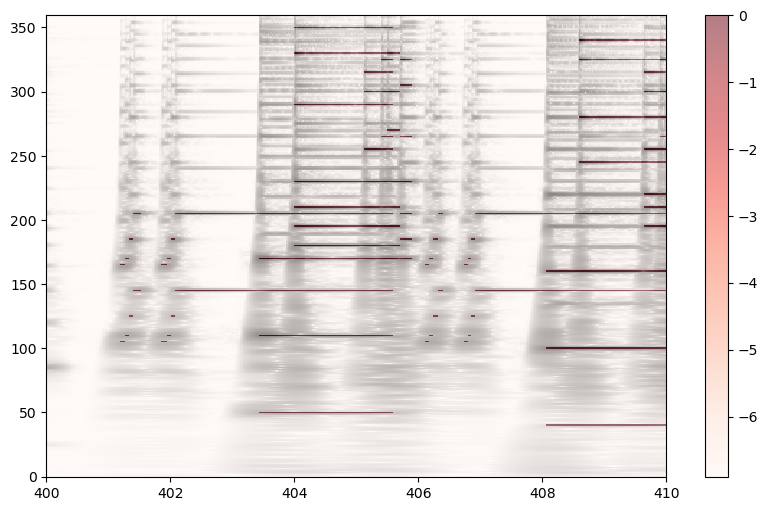

In [20]:
# --- TEST
if do_f0_annot == 'segment':
    idx_file = 4
    with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
        audio_v = hdf5_fid[audiofile_l[idx_file]][:]
        sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
    entry = data_d['collection']['entry'][idx_file]
    print(audiofile_l[idx_file])
    print(entry)

    cqt_d = Namespace()
    cqt_d.value_3m, cqt_d.time_sec_v, cqt_d.frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, param_hcqt)
    cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])

    # -------------------------------
    plt.figure(figsize=(10,6));
    D=1/2
    plt.subplot(111); 
    plt.imshow(flog(cqt_d.value_3m[param_hcqt.h_l.index(1),:,:]), aspect='auto', cmap='gray_r', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D]);
    plt.imshow(flog(cqt_d.f0_value_m), aspect='auto', cmap='Reds', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D], alpha=0.5);
    plt.colorbar();
    plt.xlim((400,410))
    # -------------------------------

### Create Dataset

In [22]:
class PitchDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        # --- only keep entries with annotation field 'f0multi'
        if do_f0_annot == 'frame':
            entry_l = [entry for entry in entry_l if len(entry['f0multi'])]

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        self.feature_d = {}
        self.patch_l = []
        
        audio_d = Namespace()
        cqt_d = Namespace()
        gt_d = Namespace()

        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for entry in entry_l:
                audio_d.file = entry['filepath'][0]['value']
                
                cqt_d.value_3m = feat_fid['/' +  audio_d.file + '/cqt_value_3m/'][:]
                cqt_d.time_sec_v = feat_fid['/' +  audio_d.file + '/cqt_time_sec_v/'][:]
                cqt_d.frequency_hz_v = feat_fid['/' +  audio_d.file + '/cqt_frequency_hz_v/'][:]

                if do_f0_annot == 'frame':
                    cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])
                elif do_f0_annot == 'segment':
                    cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])


                self.feature_d[audio_d.file] = {'X': torch.tensor(cqt_d.value_3m).float(), 'y': torch.tensor(cqt_d.f0_value_m)}
                
                localpatch_l = feature.f_get_patches(cqt_d.value_3m.shape[2], param_patch.L_frame, param_patch.STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_d.file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })
            self.cqt_d_frequency_hz_v = cqt_d.frequency_hz_v
            
    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        X = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['X'][:,:, s:e]
        y = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['y'][:,s:e]
        return {'X':X , 'y':y}
    
train_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
valid_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)

71561
15753


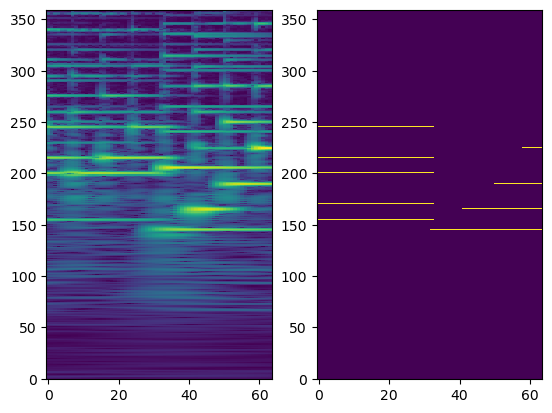

In [23]:
# --- TEST
print(len(train_dataset))
print(len(valid_dataset))

idx_path = 51
plt.subplot(121); plt.imshow(flog(train_dataset[idx_path]['X'][param_hcqt.h_l.index(1),:,:]).numpy(), aspect='auto', origin='lower', interpolation='none', );
plt.subplot(122); plt.imshow(train_dataset[idx_path]['y'][:,:].numpy(), aspect='auto', origin='lower', interpolation='none', );

### Create DataLoader

In [24]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=9)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=9)

In [25]:
# --- TEST
print(next(iter(train_dataloader))['X'].size())
print(next(iter(train_dataloader))['y'].size())

torch.Size([32, 6, 360, 64])
torch.Size([32, 360, 64])


## Model

### ConvNet-model (based on Bittner)

In [26]:
with open('config_bittner.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)

class BittnerNetModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(BittnerNetModel, self).__init__()
        self.block_l = []
        for config_block in config.model.block_l:
            sequential_l = []
            for config_sequential in config_block.sequential_l:
                component_l = []
                for config_component in config_sequential.component_l:
                    module, current_input_dim = model_factory.f_parse_component(config_component[0], config_component[1], current_input_dim) 
                    component_l.append( module )
                sequential_l.append( nn.Sequential (*component_l) )
            self.block_l.append( nn.ModuleList(sequential_l) )
        self.model = nn.ModuleList(self.block_l)

    def forward(self, X, do_verbose=False):
        for idx_block, block in enumerate(self.model):
            for idx_sequential, sequential in enumerate(block):
                if do_verbose: print(f'{idx_block}/{idx_sequential}---------------------------------\n{sequential}\n> in: {X.size()}')
                X = sequential( X )
                if do_verbose: print(f'> out: {X.size()}')
        return X

m, C, H, T = 32, len(param_hcqt.h_l), 360, 64
model = BittnerNetModel(config, [m, C, H, T])
model = model.to(param_model.device)

In [27]:
# --- TEST
#print(model)

#X = torch.randn(m, C, H, T).to(param_model.device)
#print(model(X, True).size())

torchsummary.summary(model, (C, H, T))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 6, 360, 64]              12
            Conv2d-2         [-1, 128, 360, 64]          19,328
              ReLU-3         [-1, 128, 360, 64]               0
       BatchNorm2d-4         [-1, 128, 360, 64]             256
            Conv2d-5          [-1, 64, 360, 64]         204,864
       BatchNorm2d-6          [-1, 64, 360, 64]             128
              ReLU-7          [-1, 64, 360, 64]               0
            Conv2d-8          [-1, 64, 360, 64]         102,464
       BatchNorm2d-9          [-1, 64, 360, 64]             128
           Conv2d-10          [-1, 64, 360, 64]           8,256
             ReLU-11          [-1, 64, 360, 64]               0
    ResidualBlock-12          [-1, 64, 360, 64]               0
      BatchNorm2d-13          [-1, 64, 360, 64]             128
           Conv2d-14          [-1, 64, 

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


### UNet-model (based on Doras)

In [ ]:
with open('config_doras.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)

class DorasNetModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(DorasNetModel, self).__init__()

        sequential_l = []
        for config_sequential in config.model.block_l[0].encoder_l:
            component_l = []
            for config_component in config_sequential.component_l:
                type, param = config_component[0], config_component[1]
                module, current_input_dim = model_factory.f_parse_component(type, param, current_input_dim)
                component_l.append( module )
            sequential_l.append( nn.Sequential (*component_l) )
        self.encoder = nn.ModuleList(sequential_l)

        sequential_l = []
        for config_sequential in config.model.block_l[1].decoder_l:
            component_l = []
            for config_component in config_sequential.component_l:
                type, param = config_component[0], config_component[1]
                module, current_input_dim = model_factory.f_parse_component(type, param, current_input_dim)
                component_l.append( module )
            sequential_l.append( nn.Sequential (*component_l) )
        self.decoder = nn.ModuleList(sequential_l)

    def forward(self, X, do_verbose=False):

        Xe_l = {}
        Xe_l[0] = X
        for idx_e, sequential in enumerate(self.encoder):
            if do_verbose: print(f'{idx_e}---------------------------------\n{sequential}\n> in: {Xe_l[idx_e].size()}')
            Xe_l[idx_e+1] = sequential( Xe_l[idx_e] )
            if do_verbose: print(f'> out: {Xe_l[idx_e+1].size()}')
        
        Xd_l = {}
        Xd_l[0] = Xe_l[idx_e+1]
        for idx_d, sequential in enumerate(self.decoder):
            if do_verbose: print(f'{idx_d}---------------------------------\n{sequential}\n> in: {Xd_l[idx_d].size()}')
            if idx_d>0: 
                    if do_verbose: print(f'> cat: {Xe_l[4-idx_d].size()}')
                    Xd_l[idx_d] = torch.cat( ( Xd_l[idx_d], Xe_l[idx_e+1-idx_d]), dim=1)
            Xd_l[idx_d+1] = sequential( Xd_l[idx_d] )
            if do_verbose: print(f'> out: {Xd_l[idx_d+1].size()}')
        
        return Xd_l[idx_d+1]

m, C, H, T = 32, len(param_hcqt.h_l), 360, 64
model = DorasNetModel(config, [m, C, H, T])
model = model.to(param_model.device)

In [ ]:
# --- TEST
# #print(model)

#X = torch.randn(m, C, H, T).to(param_model.device)
#print(model(X, True).size())

torchsummary.summary(model, (C, H, T))

### Test models

In [28]:
batch = next(iter(train_dataloader))
X = batch['X'].to(param_model.device)
y = batch['y'].to(param_model.device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')


torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 360, 64])


In [29]:
nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

torch.Size([32, 360, 64])

## Training using torchlighning

### W&B configuration

In [ ]:
train_config_d = {}
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
expe_name = formatted_datetime
wandb.finish()
wandb_logger = WandbLogger(project = param_wandb.project_name, name = expe_name, save_dir = param_wandb.save_dir )
wandb_logger.experiment.config.update(train_config_d)

### TorchLightning

In [30]:
class PitchLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y.squeeze(1), batch['y'])
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y.squeeze(1), batch['y'])
        self.log("valid_loss", loss, prog_bar=True)

        if batch_idx==0: 
            data_image = np.hstack( (batch['y'][0,:,:].cpu().numpy(),  nn.Sigmoid()(hat_y[0,0,:,:].detach()).cpu().numpy() ) )
            #wandb.log({'val3/f0': wandb.Image( data_image )})
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

### Training

In [31]:
my_lighting = PitchLigthing(model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=10, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
#trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please

## Evaluation


### Load best model

In [22]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = PitchLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/_pitch_lighning/best_model_pitch-v11.ckpt
<class '__main__.BittnerNetModel'>
<class '__main__.PitchLigthing'>
<class '__main__.BittnerNetModel'>


### Illustration

torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 1, 360, 64])


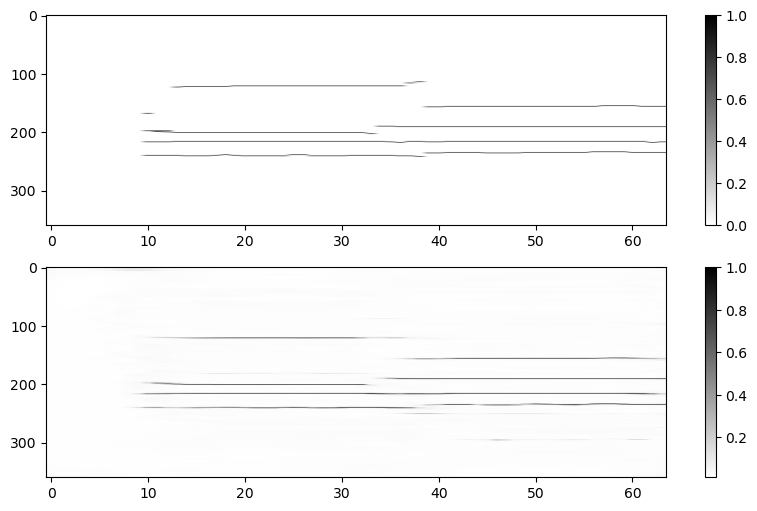

In [32]:
model.to(param_model.device)
data = next(iter(valid_dataloader))

hat_y = nn.Sigmoid()( model(data['X'].to(param_model.device)) )

print(f"{data['X'].size()} {data['y'].size()} {hat_y.size()}")

idx_patch = 0

plt.figure(figsize=(10,6));
plt.subplot(211); plt.imshow(data['y'][idx_patch,:,:].cpu().numpy(), cmap='gray_r', aspect='auto'); plt.colorbar();
plt.subplot(212); plt.imshow(hat_y[idx_patch,0,:,:].detach().cpu().numpy(), cmap='gray_r', aspect='auto'); plt.colorbar();

### Multi-Pitch: performance measures using mir_eval

In [33]:
import mir_eval
threshold = 0.5

model.to(param_model.device)

store_l = []
for data in valid_dataloader:
    hat_y = nn.Sigmoid()( model(data['X'].to(param_model.device)) )
    
    nb_patch = hat_y.size(0)
    for idx_patch in range(nb_patch):
        gt_m = data['y'][idx_patch,:,:].cpu().numpy()
        est_m = hat_y[idx_patch,0,:,:].detach().cpu().numpy()
        ref_time_l, est_time_l, ref_freqs_l, est_freqs_l = [], [], [], []

        for t in range(gt_m.shape[1]):
            ref_time_l.append( float(t) )
            ref_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ gt_m[:,t]>0 ] )
            est_time_l.append( float(t) )
            est_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ est_m[:,t]>threshold ] )

        ref_time_l = np.array(ref_time_l)
        est_time_l = np.array(est_time_l)

        dict_d = mir_eval.multipitch.evaluate(ref_time_l, ref_freqs_l, est_time_l, est_freqs_l)
        store_l.append({'Accuracy': dict_d['Accuracy'], 'gt_m': gt_m,  'est_m': est_m})

pp.pprint(dict_d)

OrderedDict([('Precision', 0.7526315789473684),
             ('Recall', 0.697560975609756),
             ('Accuracy', 0.5674603174603174),
             ('Substitution Error', 0.14634146341463414),
             ('Miss Error', 0.15609756097560976),
             ('False Alarm Error', 0.08292682926829269),
             ('Total Error', 0.3853658536585366),
             ('Chroma Precision', 0.8157894736842105),
             ('Chroma Recall', 0.7560975609756098),
             ('Chroma Accuracy', 0.6458333333333334),
             ('Chroma Substitution Error', 0.08780487804878048),
             ('Chroma Miss Error', 0.15609756097560976),
             ('Chroma False Alarm Error', 0.08292682926829269),
             ('Chroma Total Error', 0.32682926829268294)])


0.7548914913511418


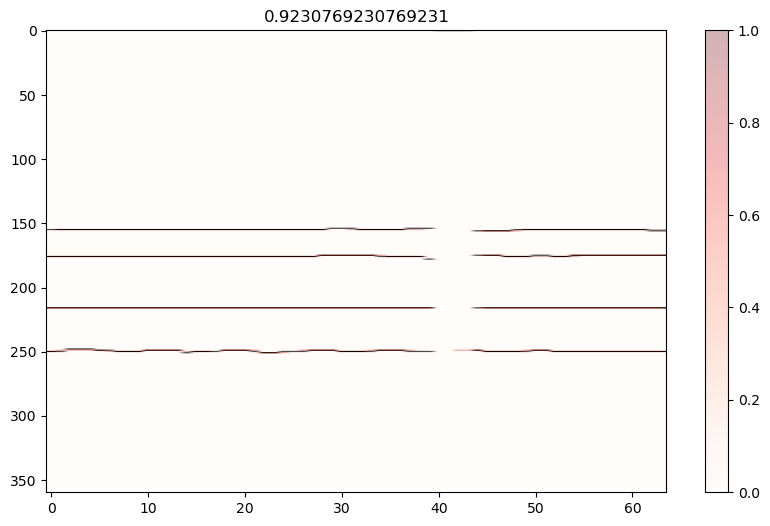

In [31]:
# Bittner: Bach10: Conv2D: 73% Conv2dDS: 67.8% Conv2DRes: 75.1% ConvNext: 78.5%
# w/o HCQT -> 56%
# Doras: 
print( np.mean([store['Accuracy'] for store in store_l]) )
pos = np.argmax([store['Accuracy'] for store in store_l])

plt.figure(figsize=(10,6));
plt.subplot(111); 
plt.imshow(store_l[pos]['gt_m'], cmap='gray_r', aspect='auto'); 
plt.imshow(store_l[pos]['est_m']>0.5, cmap='Reds', aspect='auto', alpha=0.3); 
plt.colorbar()
plt.title(store_l[pos]['Accuracy']);